In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Dense, Activation, add, Flatten, GlobalAveragePooling2D, Reshape, multiply
from keras.models import Model

import numpy as np
import tensorflow as tf
from keras.utils import np_utils

width = 32
height = 32

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


170498071/170498071 [==============================] - 5s 0us/step


In [ ]:
y_train.shape

(50000, 1)

In [ ]:
num_classes = 10
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [ ]:
y_train.shape

(50000, 10)

In [ ]:
validation_images, validation_labels = x_train[:500], y_train[:500]
train_images, train_labels = x_train[500:], y_train[500:]

In [ ]:
y_train.shape

(50000, 10)

In [ ]:
def Residual_Block(x, filter):

    x_skip = x 
    f= filter

    x = Conv2D(f, kernel_size=(3,3), strides=1, padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(f, kernel_size=(3,3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x_skip = Conv2D(f, kernel_size=(1,1),strides=(1,1),padding='same')(x_skip)
    x_skip = BatchNormalization()(x_skip)    


    x = add([x, x_skip])
    x = Activation('relu')(x)    
    
    return x


In [ ]:
def SEmodule(pre_layer, ch, r):

    x = GlobalAveragePooling2D()(pre_layer)
    x = Dense(int(ch/r), activation='relu')(x)
    x = Dense(ch, activation='sigmoid')(x)
    x = Reshape((1, 1, ch))(x)
    x = multiply([pre_layer,x])
    
    return x

In [ ]:
def Residual_Block_50(x, filters):
    f1, f2 = filters
    x_skip = x # 초기의 x
    
    #SE module 적용
    x = Conv2D(f1, kernel_size=(1,1), strides=1, padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f1, kernel_size=(3,3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, kernel_size=(1,1), strides=1, padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = SEmodule(x, f2, 16) #최종 channel수만 더함 

    #scale
    x_skip = Conv2D(f2, kernel_size=(1,1),strides=(1,1),padding='same')(x_skip)
    x_skip = BatchNormalization()(x_skip)    

    #skip connection
    x = add([x, x_skip])
    x = Activation('relu')(x)    
    
    return x

In [ ]:

inputs = Input(shape=(32,32,3))
x = Conv2D(64, kernel_size=7, strides=2, padding='valid')(inputs)
x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)

# for i in range(3):
#   x = Residual_Block_50(x, filter = [64, 256])

# x = Residual_Block(x, filter = 64)

# x = Residual_Block(x, filter = 128)
# x = Residual_Block(x, filter = 128)

# x = Residual_Block(x, filter = 256)
# x = Residual_Block(x, filter = 256)

# x = Residual_Block(x, filter = 512)
# x = Residual_Block(x, filter = 512)
for i in range(3):
  x = Residual_Block_50(x, filters=(64,256)) 

for i in range(4):
  x = Residual_Block_50(x, filters =(128,512)) 

for i in range(6):
  x = Residual_Block_50(x, filters =(256,1024)) 

for i in range(3):
  x = Residual_Block_50(x, filters =(512,2048)) 


x = GlobalAveragePooling2D()(x) 

outputs = Dense(10, activation = 'softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 13, 13, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 7, 7, 64)     0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     4160        ['max_pooling2d[0][0]']          
                                                                                              

In [ ]:
from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


In [ ]:
train_datagen.fit(train_images)
validation_datagen.fit(validation_images)

In [ ]:
history = model.fit_generator(train_datagen.flow(train_images,train_labels, batch_size = 32), 
                    validation_data = validation_datagen.flow(validation_images, validation_labels, batch_size = 32),
                    epochs = 10)

<ipython-input-13-2a75ee7e08c3>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(train_images,train_labels, batch_size = 32),


Epoch 1/10
1547/1547 [==============================] - 289s 166ms/step - loss: 1.7552 - accuracy: 0.3473 - val_loss: 1.8331 - val_accuracy: 0.3800
Epoch 2/10
1547/1547 [==============================] - 255s 165ms/step - loss: 1.4528 - accuracy: 0.4755 - val_loss: 1.3674 - val_accuracy: 0.5140
Epoch 3/10
1547/1547 [==============================] - 254s 164ms/step - loss: 1.2747 - accuracy: 0.5448 - val_loss: 1.3326 - val_accuracy: 0.5140
Epoch 4/10
1547/1547 [==============================] - 253s 163ms/step - loss: 1.1409 - accuracy: 0.5934 - val_loss: 1.2316 - val_accuracy: 0.5440
Epoch 5/10
1547/1547 [==============================] - 255s 165ms/step - loss: 1.0415 - accuracy: 0.6320 - val_loss: 1.2023 - val_accuracy: 0.5780
Epoch 6/10
1547/1547 [==============================] - 252s 163ms/step - loss: 0.9605 - accuracy: 0.6618 - val_loss: 1.5748 - val_accuracy: 0.4800
Epoch 7/10
1547/1547 [==============================] - 252s 163ms/step - loss: 0.8917 - accuracy: 0.6852 - val_

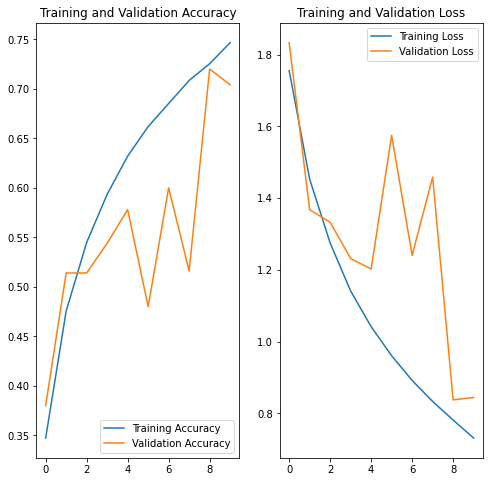

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()